In [ ]:
!pip install kaggle

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 97% 641M/663M [00:10<00:00, 162MB/s]
100% 663M/663M [00:10<00:00, 68.8MB/s]


In [ ]:
!unzip /content/tuberculosis-tb-chest-xray-dataset.zip

Archive:  /content/tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1009.png 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# Settings
image_size = (64, 64)
data_path = "/content/TB_Chest_Radiography_Database"
labels = ['Normal', 'Tuberculosis']

X, Y = [], []
for idx, label in enumerate(labels):
    folder = os.path.join(data_path, label)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            X.append(img)
            Y.append(idx)

X = np.array(X) / 255.0  # Normalize
Y = to_categorical(np.array(Y), num_classes=2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [ ]:
def create_simple_cnn(input_shape=(64, 64, 3), num_classes=2):
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_simple_cnn()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def gradcam_simple(model, image, label_names):
    img_tensor = np.expand_dims(image, axis=0)
    last_conv_layer_name = 'conv2d_1'  # second conv layer

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_output = conv_output[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed = cv2.addWeighted((image * 255).astype(np.uint8), 0.6, heatmap_color, 0.4, 0)

    plt.imshow(superimposed)
    plt.title(f"Predicted: {label_names[class_idx]}")
    plt.axis('off')
    plt.show()


In [ ]:
def create_simple_cnn_functional(input_shape=(64, 64, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (3, 3), activation='relu', name="conv1")(inputs)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(32, (3, 3), activation='relu', name="conv2")(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Rebuild and retrain the model
model = create_simple_cnn_functional()
history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test))


Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8691 - loss: 0.3486 - val_accuracy: 0.9429 - val_loss: 0.1587
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9476 - loss: 0.1526 - val_accuracy: 0.9571 - val_loss: 0.1339
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9636 - loss: 0.1104 - val_accuracy: 0.9690 - val_loss: 0.0830
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9766 - loss: 0.0729 - val_accuracy: 0.9738 - val_loss: 0.0745
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9824 - loss: 0.0541 - val_accuracy: 0.9750 - val_loss: 0.0688


In [ ]:
def gradcam_simple(model, image, label_names):
    img_tensor = np.expand_dims(image, axis=0)
    last_conv_layer_name = 'conv2'  # Use the correct name from above

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted((image * 255).astype(np.uint8), 0.6, heatmap_color, 0.4, 0)

    plt.imshow(superimposed)
    plt.title(f"Predicted: {label_names[class_idx]}")
    plt.axis('off')
    plt.show()


In [ ]:

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Add, BatchNormalization
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    """
    A simple block consisting of two convolutional layers followed by batch normalization.
    """
    x = Conv2D(filters, kernel_size, padding=padding, activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding=padding, activation=activation)(x)
    x = BatchNormalization()(x)
    return x

def build_hybrid_model(input_shape=(64, 64, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # First Block - Convolutional Layer + MaxPooling (VGG-like)
    x = conv_block(inputs, 64)
    residual_1 = x
    x = MaxPooling2D((2, 2))(x)

    # Second Block
    x = conv_block(x, 128)
    residual_2 = x
    x = MaxPooling2D((2, 2))(x)

    # Third Block
    x = conv_block(x, 256)
    residual_3 = x
    x = MaxPooling2D((2, 2))(x)

    # Fourth Block
    x = conv_block(x, 512)
    residual_4 = x
    x = MaxPooling2D((2, 2))(x)

    # Fifth Block
    x = conv_block(x, 512)
    residual_5 = x
    x = MaxPooling2D((2, 2))(x)

    # Add residual connections after the blocks
    x = Add()([x, residual_4])  # Skip connection after 4th block
    x = Add()([x, residual_3])  # Skip connection after 3rd block
    x = Add()([x, residual_2])  # Skip connection after 2nd block
    x = Add()([x, residual_1])  # Skip connection after 1st block

    # Flatten and Fully Connected Layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)  # Dropout for regularization
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = build_deeper_cnn()
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8469 - loss: 0.3856 - val_accuracy: 0.9381 - val_loss: 0.1559
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9413 - loss: 0.1526 - val_accuracy: 0.9536 - val_loss: 0.1079
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9679 - loss: 0.0871 - val_accuracy: 0.9595 - val_loss: 0.0897
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9822 - loss: 0.0535 - val_accuracy: 0.9750 - val_loss: 0.0653
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9833 - loss: 0.0448 - val_accuracy: 0.9762 - val_loss: 0.0639
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9843 - loss: 0.0455 - val_accuracy: 0.9726 - val_loss: 0.1215
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9888 - loss: 0.0385 - val_accuracy: 0.9798 - val_loss: 0.0657
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9934 - loss: 0.0203 - val_accur

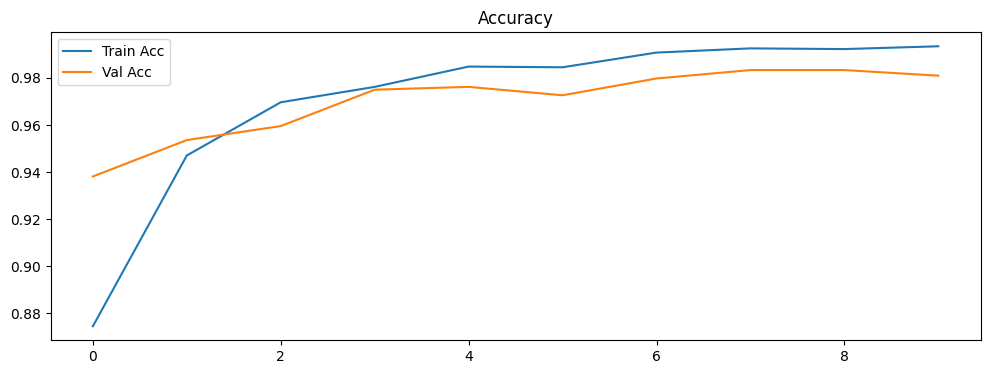

<Figure size 1200x400 with 0 Axes>

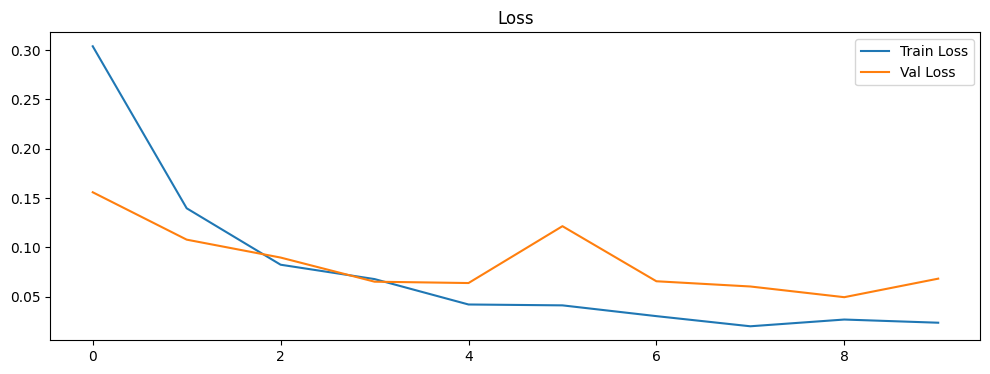

In [ ]:
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.show()
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_metrics(history)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


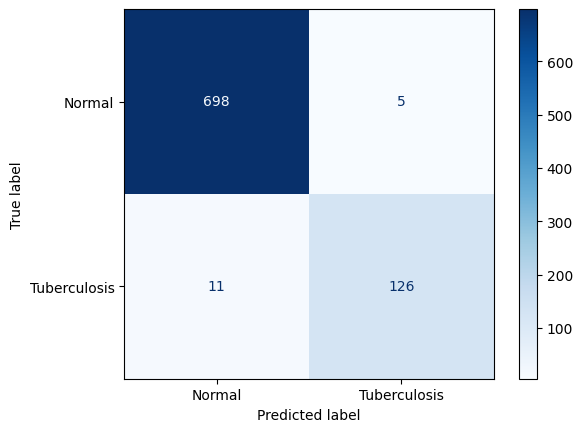

In [ ]:
y_pred = model.predict(X_test)
y_true = np.argmax(Y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()


In [ ]:
def gradcam_simple(model, image, label_names):
    img_tensor = np.expand_dims(image, axis=0)
    last_conv_layer_name = 'conv4'

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted((image * 255).astype(np.uint8), 0.6, heatmap_color, 0.4, 0)

    plt.imshow(superimposed)
    plt.title(f"Predicted: {label_names[class_idx]}")
    plt.axis('off')
    plt.show()


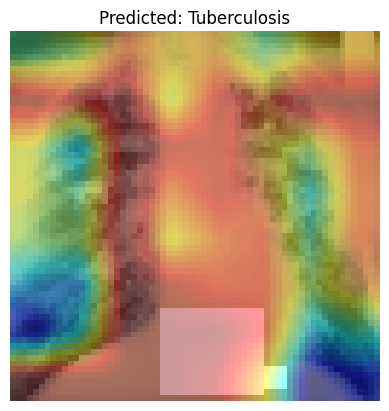

In [ ]:
sample_image = X_test[500]
gradcam_simple(model, sample_image, labels)



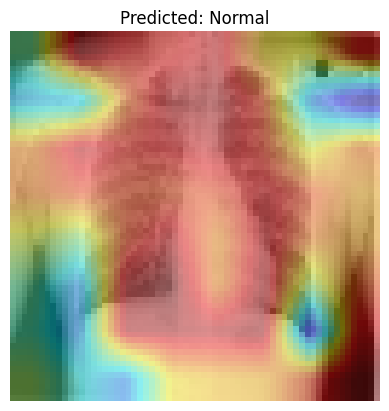

In [ ]:
sample_image = X_test[600]
gradcam_simple(model, sample_image, labels)


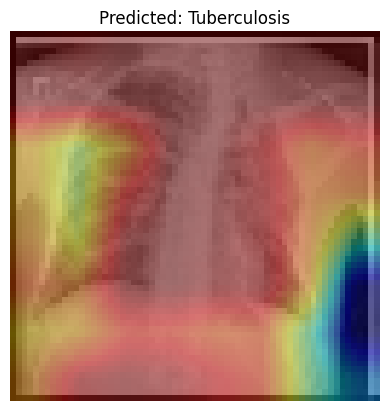

In [ ]:
sample_image = X_test[102]
gradcam_simple(model, sample_image, labels)


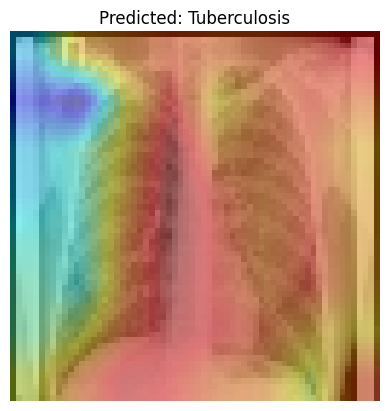

In [ ]:
sample_image = X_train[349]
gradcam_simple(model, sample_image, labels)


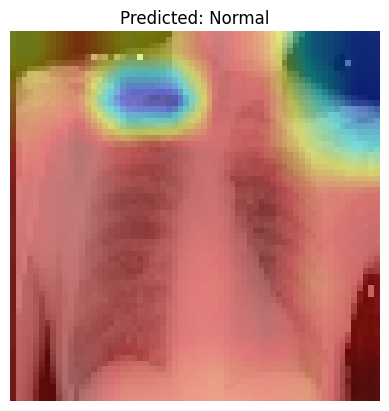

In [ ]:
sample_image = X_train[]
gradcam_simple(model, sample_image, labels)
